# Forecasting Fashion Demand using Clustering and Statistical methods

# I. Data Pre-processing

## 0. Imports

In [330]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from ydata_profiling import ProfileReport
from statsmodels.tsa.seasonal import seasonal_decompose

In [4]:
os.getcwd()

'c:\\Users\\MaximeRoux\\OneDrive - Samsøe & Samsøe Wholesale ApS\\Documents\\Operations\\S&OP\\Forecasting\\Basics'

In [2]:
# Configure seaborn plot style: set background color and use dark grid
sns.set(rc={'axes.facecolor':'#E6E6E6'}, style='darkgrid')

In [146]:
# Importing the dataset
df = pd.read_csv('sales_invoiced_lines_basics_v2.csv')

In [147]:
# The dataframe is relatively large and we want to visualise it as a scrollable element
pd.set_option('display.max_columns', None)

## 1. Data cleaning

In [148]:
df.head()

,Unnamed: 0,Id,DimEntityId,DimOrderTypeId,OrderTypeCode,DimGeographyId,Country,DimPostingDateId,DimGenderId,DimBillToCustomerId,CustomerMainType,CustomerSubGroup,DimCollectionId,DimItemId,ItemNo2,StyleID,Style,Color,Size,EAN,Gender,Category,SUB Category,SUB Category2,Quality,Origin Country,WHSSalesPriceDKK,RRSalesPriceDKK,DimOrderSalespersonId,DimOrderCountryManagerId,OrderHeaderNumber,OrderLineNumber,Inbound Duty,Quantity,Amount,Discount,Cost
0,0,139269,43,222,B2BSUP,71,Finland,20220312,2,1718,WHOLESALE,FI,54,347900,F15404308_CLR000021,F15404308,Hoys pants 6528,Black,XL,5.711450e+12,WOMENSWEAR,Trousers,Trousers,Default,Woven,China,315.0,800.0,113,2,103099,20001,0.12,1.0,294.63,17.71,152.91
1,1,139865,43,222,B2BSUP,71,Finland,20220312,2,1718,WHOLESALE,FI,54,347900,F15404308_CLR000021,F15404308,Hoys pants 6528,Black,XL,5.711450e+12,WOMENSWEAR,Trousers,Trousers,Default,Woven,China,315.0,800.0,113,2,103106,20002,0.12,2.0,589.26,35.34,305.80
2,2,137984,43,222,B2BSUP,20,Belgium,20220312,1,1462,WHOLESALE,BE,54,778,M00012003_CLR000508,M00012003,Kronos o-n ss 273,White mel,S,5.711452e+12,MENSWEAR,Tops,Crew neck,Short sleeve,Jersey,Turkey,90.0,250.0,282,3,103035,20002,0.00,1.0,78.12,0.00,42.41
3,3,195101,43,222,B2BSUP,57,Germany,20220312,2,1231,WHOLESALE,DE-2,54,348547,F19123672_CLR000021,F19123672,Majan ss shirt 9942,Black,L,5.711452e+12,WOMENSWEAR,Shirts,Shirts,Short sleeve,Woven,China,195.0,500.0,96,6,IN0001122,60002,0.12,2.0,379.45,0.00,147.84
4,4,138577,43,222,B2BSUP,57,Germany,20220312,2,1231,WHOLESALE,DE-2,54,348547,F19123672_CLR000021,F19123672,Majan ss shirt 9942,Black,L,5.711452e+12,WOMENSWEAR,Shirts,Shirts,Short sleeve,Woven,China,195.0,500.0,85,6,103113,40003,0.12,2.0,379.45,0.00,162.08


In [149]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 826690 entries, 0 to 826689
Data columns (total 37 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Unnamed: 0                826690 non-null  int64  
 1   Id                        826690 non-null  int64  
 2   DimEntityId               826690 non-null  int64  
 3   DimOrderTypeId            826690 non-null  int64  
 4   OrderTypeCode             826690 non-null  object 
 5   DimGeographyId            826690 non-null  int64  
 6   Country                   826690 non-null  object 
 7   DimPostingDateId          826690 non-null  int64  
 8   DimGenderId               826690 non-null  int64  
 9   DimBillToCustomerId       826690 non-null  int64  
 10  CustomerMainType          826690 non-null  object 
 11  CustomerSubGroup          826690 non-null  object 
 12  DimCollectionId           826690 non-null  int64  
 13  DimItemId                 826690 non-null  i

In [150]:
# Handling missing values: we notice missing values for EAN, sub category, sub category 2, quality, Inbound duties
# EAN -  Using DimItemId we have an identifiant of product at a Style x Color x Size level. Using ItemNo2, we have Style x Color level. Using StyleID, we have an identifiant at a style level.
# We conclude we can remove EAN as it isn't bringing more information.
df.drop('EAN', axis=1, inplace=True)

In [151]:
# Sub category and sub category 2
unique_cat = df[['Category','SUB Category','SUB Category2']].drop_duplicates()
unique_cat
# NaNs in the product categories are coming solely from Sunglasses. In order to comply with the rest of the categories, we will replace NaN in SUB Category by 'Sunglasses' and SUB Category2 by 'Default'
df['SUB Category'].fillna('Sunglasses', inplace=True)
df['SUB Category2'].fillna('Default', inplace=True)

C:\Users\MaximeRoux\AppData\Local\Temp\ipykernel_22412\3534567760.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['SUB Category'].fillna('Sunglasses', inplace=True)
C:\Users\MaximeRoux\AppData\Local\Temp\ipykernel_22412\3534567760.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a

In [152]:
# Quality
print(f'There are {df[df['Quality'].isna()]['Style'].nunique()} styles without quality.')
# We think we can replace the values by investigating online what is the fabric.
df[df['Quality'].isna()]['Style'].unique()

There are 45 styles without quality.


array(['Camino t-shirt ss 6024', 'Merkur t-n ls 200',
       'Knud t-shirt st 10379', 'Siffy ls body 10908',
       'Tandy panties 6356', 'Eddie jeans 13026', 'Hugo crew neck 11414',
       'Marilyn bra 6356', 'Siff tee 6202', 'Liss ss gd 3174',
       'Mains tee 5687', 'Kronos o-n ss 273', 'Alice jeans 11364',
       'Alice jeans 10232', 'Liam BX shirt 11246', 'Enno hoodie ls 7057',
       'Nelli ls 9400', 'Holger socks 11517', 'Rory jeans 14031',
       'Nobel ls stripe 3173', 'Hugo hoodie 11414',
       'Kleo turtleneck 11265', 'Ester t-n 265', 'Alaya jeans 11363',
       'Alice jeans 11363', 'Sarai wrap ls 12708', 'Siff tee 13114',
       'Kleo cardigan 11265', 'Edger A blazer 6568',
       'Kleo crew neck 11265', 'Rory jeans 13047', 'Cosmo jeans 11358',
       'Patrick o-n ss 10379', 'Kronos o-n stripe 273',
       'Alaya jeans 10232', 'Trunks 3702', 'Enno zip hoodie 7057',
       'Cosmo jeans 13047', 'Rory jeans 11358', 'Solly tee solid 205',
       'Rory jeans 11005', 'Tom o-n s

In [153]:
df['Quality'].unique()

array(['Woven', 'Jersey', nan, 'Denim', 'Knit', 'Leather', 'Shoes',
       'Other'], dtype=object)

In [154]:
NaN_quality_dict = {'Camino t-shirt ss 6024' : 'Jersey',
                     'Merkur t-n ls 200' : 'Jersey',
                     'Knud t-shirt st 10379' : 'Other', 
                     'Siffy ls body 10908' : 'Other',
                     'Tandy panties 6356' : 'Jersey',
                     'Eddie jeans 13026' : 'Denim',
                     'Hugo crew neck 11414' : 'Jersey',
                     'Marilyn bra 6356' : 'Jersey',
                     'Siff tee 6202' : 'Other',
                     'Liss ss gd 3174' : 'Jersey',
                     'Mains tee 5687' : 'Woven',
                     'Kronos o-n ss 273' : 'Jersey',
                     'Alice jeans 11364' : 'Denim',
                     'Alice jeans 10232' : 'Denim',
                     'Liam BX shirt 11246' : 'Woven', 
                     'Enno hoodie ls 7057' : 'Other',
                     'Nelli ls 9400' : 'Jersey',
                     'Holger socks 11517' : 'Knit',
                     'Rory jeans 14031' : 'Denim',
                     'Nobel ls stripe 3173' : 'Jersey', 
                     'Hugo hoodie 11414' : 'Other',
                     'Kleo turtleneck 11265' : 'Knit', 
                     'Ester t-n 265' : 'Jersey', 
                     'Alaya jeans 11363' : 'Denim',
                     'Alice jeans 11363' : 'Denim',
                     'Sarai wrap ls 12708' : 'Other',
                     'Siff tee 13114' : 'Jersey',
                     'Kleo cardigan 11265' : 'Knit',
                     'Edger A blazer 6568' : 'Other',
                     'Kleo crew neck 11265' : 'Other',
                     'Rory jeans 13047' : 'Denim',
                     'Cosmo jeans 11358' : 'Denim',
                     'Patrick o-n ss 10379' : 'Jersey',
                     'Kronos o-n stripe 273' : 'Jersey',
                     'Alaya jeans 10232' : 'Denim',
                     'Trunks 3702' : 'Other',
                     'Enno zip hoodie 7057' : 'Other',
                     'Cosmo jeans 13047' : 'Denim',
                     'Rory jeans 11358' : 'Denim',
                     'Solly tee solid 205' : 'Jersey',
                     'Rory jeans 11005' : 'Denim',
                     'Tom o-n ss 10076' : 'Other',
                     'Adelina jeans 14145' : 'Other',
                     'Amie ls 2085' : 'Jersey',
                     'Sunglasses Display' : 'Other'}

In [155]:
for i in NaN_quality_dict:
    df.loc[df['Style']==i,['Quality']]=NaN_quality_dict[i]

In [156]:
df['Quality'].unique()

array(['Woven', 'Jersey', 'Denim', 'Other', 'Knit', 'Leather', 'Shoes'],
      dtype=object)

In [157]:
# Inbound duties - We will not use this feature
df.drop('Inbound Duty', axis=1, inplace=True)

In [158]:
df.info()
# No more NaN values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 826690 entries, 0 to 826689
Data columns (total 35 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Unnamed: 0                826690 non-null  int64  
 1   Id                        826690 non-null  int64  
 2   DimEntityId               826690 non-null  int64  
 3   DimOrderTypeId            826690 non-null  int64  
 4   OrderTypeCode             826690 non-null  object 
 5   DimGeographyId            826690 non-null  int64  
 6   Country                   826690 non-null  object 
 7   DimPostingDateId          826690 non-null  int64  
 8   DimGenderId               826690 non-null  int64  
 9   DimBillToCustomerId       826690 non-null  int64  
 10  CustomerMainType          826690 non-null  object 
 11  CustomerSubGroup          826690 non-null  object 
 12  DimCollectionId           826690 non-null  int64  
 13  DimItemId                 826690 non-null  i

In [159]:
# Remove the non commercial subgroups: internal channels
subgrouptoremove = ['X_PR', 'X_SHOWROOM', 'X_OTHER', 'X_IC','Ungrouped']
dfsales = df[~df['CustomerSubGroup'].isin(subgrouptoremove)]

As explained in the document, for business reason, we have decided to focus on the product hierarchy rather than the geographical hierarchy. Hence, we decide to remove all the information related to the customer hierarchy.

In [ ]:
dfsales = dfsales.drop(['DimOrderTypeId', 'OrderTypeCode', 'DimGeographyId', 'Country', 'DimBillToCustomerId', 'CustomerMainType', 'CustomerSubGroup',
                      'DimOrderSalespersonId', 'DimOrderCountryManagerId'], axis=1)

In [ ]:
# The following columns are useless: Unnamed: 0 - SQL extract index, Id - Id coming from the initial table, DimEntityId - Unique value corresponding to the brand Samsøe Samsøe, DimCollectionId - Unique value corresponding
# to the Basic collection
df_sales.drop(['Unnamed: 0', 'Id', 'DimEntityId', 'DimCollectionId'], axis=1, inplace=True)

In [ ]:
# Create timeseries and change idex
df_sales['DimPostingDateId'] = pd.to_datetime(df_sales['DimPostingDateId'],format='%Y%m%d')
df_sales.set_index("DimPostingDateId", inplace=True)

In [ ]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 818375 entries, 2022-03-12 to 2024-11-18
Data columns (total 21 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   DimGenderId        818375 non-null  int64  
 1   DimItemId          818375 non-null  int64  
 2   ItemNo2            818375 non-null  object 
 3   StyleID            818375 non-null  object 
 4   Style              818375 non-null  object 
 5   Color              818375 non-null  object 
 6   Size               818375 non-null  object 
 7   Gender             818375 non-null  object 
 8   Category           818375 non-null  object 
 9   SUB Category       818375 non-null  object 
 10  SUB Category2      818375 non-null  object 
 11  Quality            818375 non-null  object 
 12  Origin Country     818375 non-null  object 
 13  WHSSalesPriceDKK   818375 non-null  float64
 14  RRSalesPriceDKK    818375 non-null  float64
 15  OrderHeaderNumber  818375 non-null 

In [ ]:
df_sales.to_csv("cleaned_data.csv")

# II. Exploratory Data Analysis

In [255]:
df_sales = pd.read_csv("cleaned_data.csv", index_col=0)

## 1. Data Overview and Descriptive Statistics

### Overview

In [256]:
df_sales.head()

,DimGenderId,DimItemId,ItemNo2,StyleID,Style,Color,Size,Gender,Category,SUB Category,SUB Category2,Quality,Origin Country,WHSSalesPriceDKK,RRSalesPriceDKK,OrderHeaderNumber,OrderLineNumber,Quantity,Amount,Discount,Cost
DimPostingDateId,,,,,,,,,,,,,,,,,,,,,
2022-03-12,2,347900,F15404308_CLR000021,F15404308,Hoys pants 6528,Black,XL,WOMENSWEAR,Trousers,Trousers,Default,Woven,China,315.0,800.0,103099,20001,1.0,294.63,17.71,152.91
2022-03-12,2,347900,F15404308_CLR000021,F15404308,Hoys pants 6528,Black,XL,WOMENSWEAR,Trousers,Trousers,Default,Woven,China,315.0,800.0,103106,20002,2.0,589.26,35.34,305.80
2022-03-12,1,778,M00012003_CLR000508,M00012003,Kronos o-n ss 273,White mel,S,MENSWEAR,Tops,Crew neck,Short sleeve,Jersey,Turkey,90.0,250.0,103035,20002,1.0,78.12,0.00,42.41
2022-03-12,2,348547,F19123672_CLR000021,F19123672,Majan ss shirt 9942,Black,L,WOMENSWEAR,Shirts,Shirts,Short sleeve,Woven,China,195.0,500.0,IN0001122,60002,2.0,379.45,0.00,147.84
2022-03-12,2,348547,F19123672_CLR000021,F19123672,Majan ss shirt 9942,Black,L,WOMENSWEAR,Shirts,Shirts,Short sleeve,Woven,China,195.0,500.0,103113,40003,2.0,379.45,0.00,162.08


### Volumetry 

In [257]:
print("Dataset size: " + str(df_sales.shape))
# We have 3 ladder of items: The style, it is the design of an item. The style with a specific color is called a product. The style x color x size is called a SKU.
print("Number of styles: " + str(df_sales['StyleID'].nunique()))
print("Number of products: " + str(df_sales['ItemNo2'].nunique()))
print("Number of SKUs: " + str(df_sales['DimItemId'].nunique()))

Dataset size: (818375, 21)
Number of styles: 322
Number of products: 700
Number of SKUs: 4359


### Data Types

In [258]:
df_sales.dtypes

DimGenderId            int64
DimItemId              int64
ItemNo2               object
StyleID               object
Style                 object
Color                 object
Size                  object
Gender                object
Category              object
SUB Category          object
SUB Category2         object
Quality               object
Origin Country        object
WHSSalesPriceDKK     float64
RRSalesPriceDKK      float64
OrderHeaderNumber     object
OrderLineNumber        int64
Quantity             float64
Amount               float64
Discount             float64
Cost                 float64
dtype: object

In [259]:
df_sales.index = pd.to_datetime(df_sales.index, format="%Y-%m-%d")

### Description

In [260]:
df_sales.describe(include="float")

,WHSSalesPriceDKK,RRSalesPriceDKK,Quantity,Amount,Discount,Cost
count,818375.000000,818375.000000,818375.000000,818375.000000,818375.000000,818375.000000
mean,234.737225,603.471367,1.872136,441.772587,50.959565,178.263226
std,144.077196,360.547892,4.430286,815.981699,259.153296,339.761034
min,0.000000,0.000000,-1.000000,-477.380000,-477.380000,-453.360000
25%,110.000000,300.000000,1.000000,176.090000,0.000000,61.700000
50%,195.000000,500.000000,1.000000,307.950000,13.570000,123.830000
75%,320.000000,800.000000,2.000000,500.000000,36.560000,187.910000
max,1480.000000,3700.000000,1500.000000,215758.560000,52976.000000,75360.000000


In [261]:
df_sales.describe(include="object")

,ItemNo2,StyleID,Style,Color,Size,Gender,Category,SUB Category,SUB Category2,Quality,Origin Country,OrderHeaderNumber
count,818375,818375,818375,818375,818375,818375,818375,818375,818375,818375,818375,818375
unique,700,322,323,176,68,3,18,30,5,7,7,108656
top,M00012003_CLR000023,M00012003,Kronos o-n ss 273,Black,M,WOMENSWEAR,Tops,Crew neck,Short sleeve,Jersey,China,IN0149693
freq,18564,76833,76833,229953,182660,416289,377830,335886,274536,432931,397313,716


### Report

In [262]:
# Generate the report
profile = ProfileReport(df_sales, title="Sales of Basic Product")

# Save the report to .html
profile.to_file("BasicSales.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

c:\Users\MaximeRoux\anaconda3\Lib\site-packages\ydata_profiling\model\correlations.py:66: UserWarning: There was an attempt to calculate the auto correlation, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(correlations={"auto": {"calculate": False}})`
If this is problematic for your use case, please report this as an issue:
https://github.com/ydataai/ydata-profiling/issues
(include the error message: 'cannot reindex on an axis with duplicate labels')
  warnings.warn(


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## 2. Feature Assessment and Visualization

### Univariate

#### Sales Pattern

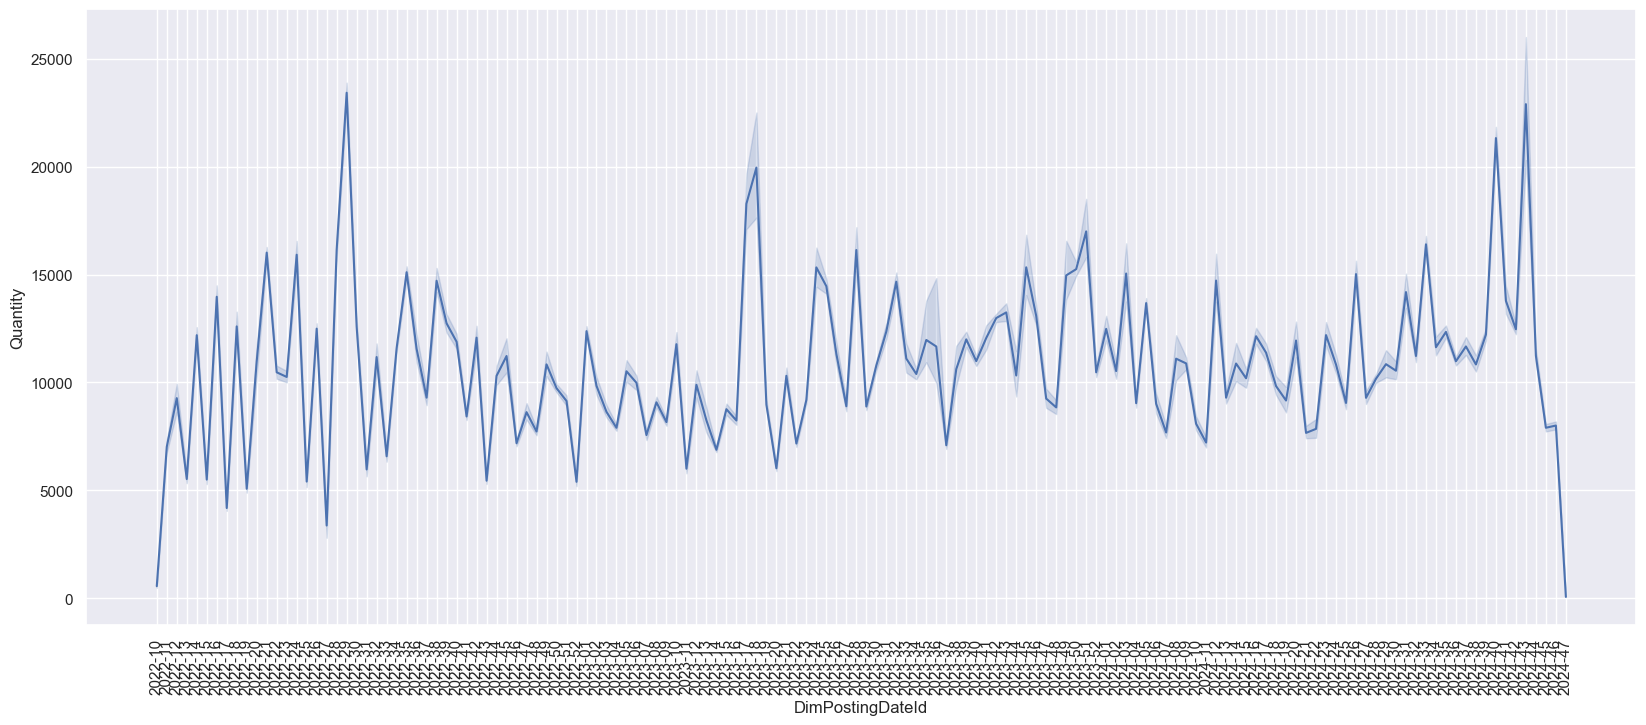

In [263]:
sns.set(rc={'figure.figsize': (20,8)})
ax = sns.lineplot(data=df_sales,y="Quantity", x=df_sales.index.strftime("%Y-%W"), estimator="sum")
ax.tick_params(axis="x", rotation=90)

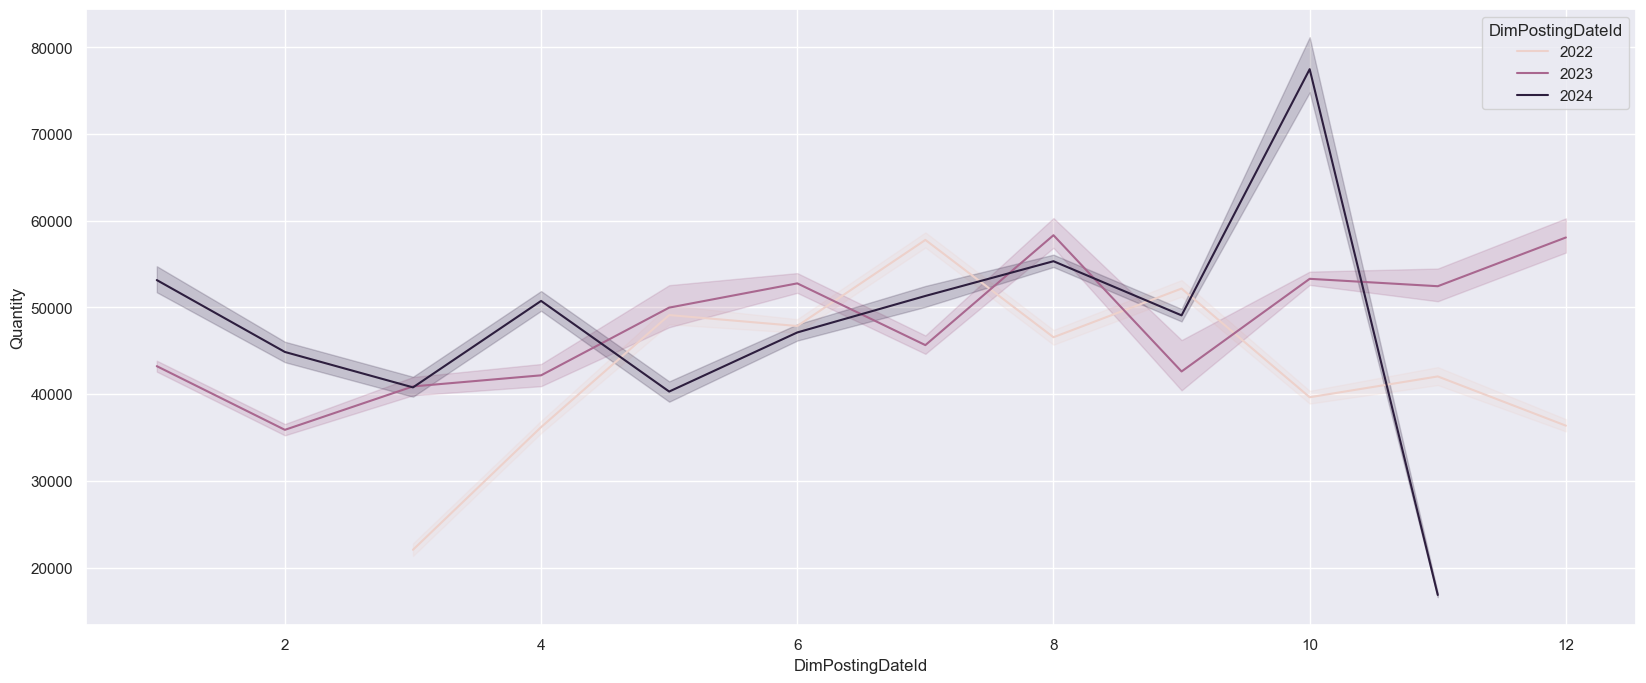

In [264]:
sns.set(rc={'figure.figsize': (20,8)})
ax = sns.lineplot(data=df_sales,y="Quantity", x=df_sales.index.month, estimator="sum", hue=df_sales.index.year)
ax.tick_params(axis="x", rotation=0)


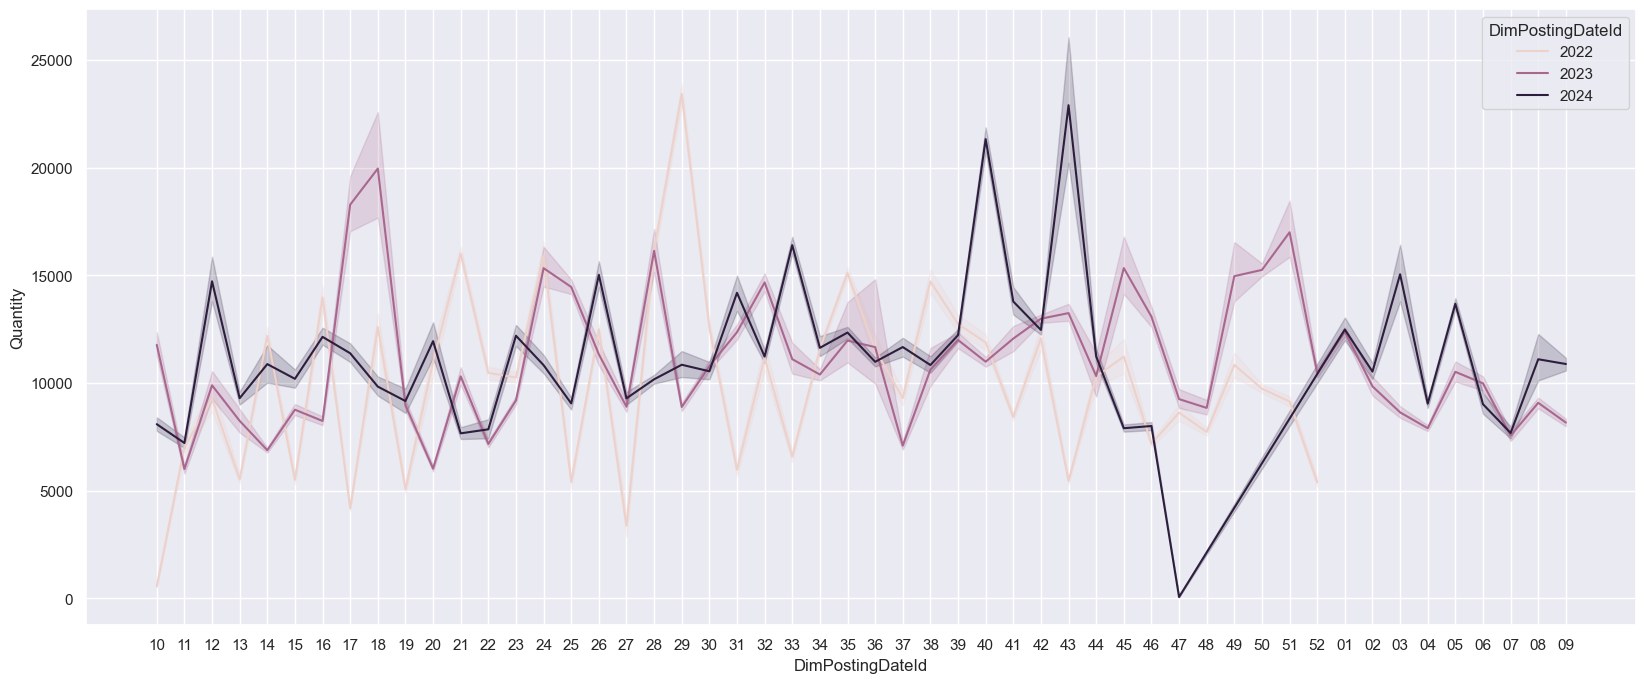

In [ ]:
sns.set(rc={'figure.figsize': (20,8)})
ax = sns.lineplot(data=df_sales,y="Quantity", x=df_sales.index.strftime("%W"),estimator="sum", hue=df_sales.index.year)
ax.tick_params(axis="x", rotation=0)

#### Product categories

In [265]:
unique_product_cat = df_sales[['Category','SUB Category','SUB Category2']].drop_duplicates()
unique_product_cat.sort_values(by=['Category', 'SUB Category', 'SUB Category2']).reset_index(drop=True)

,Category,SUB Category,SUB Category2
0,Accessories,Accessories,Default
1,Bags,Tote,Default
2,Blazers,Blazers,Default
3,Blazers,Blazers,Long sleeve
4,Dresses,Maxi,Default
5,Dresses,Maxi,Long sleeve
6,Dresses,Maxi,Sleeveless
7,Dresses,Midi,Default
8,Dresses,Midi,Long sleeve
9,Dresses,Midi,Sleeveless


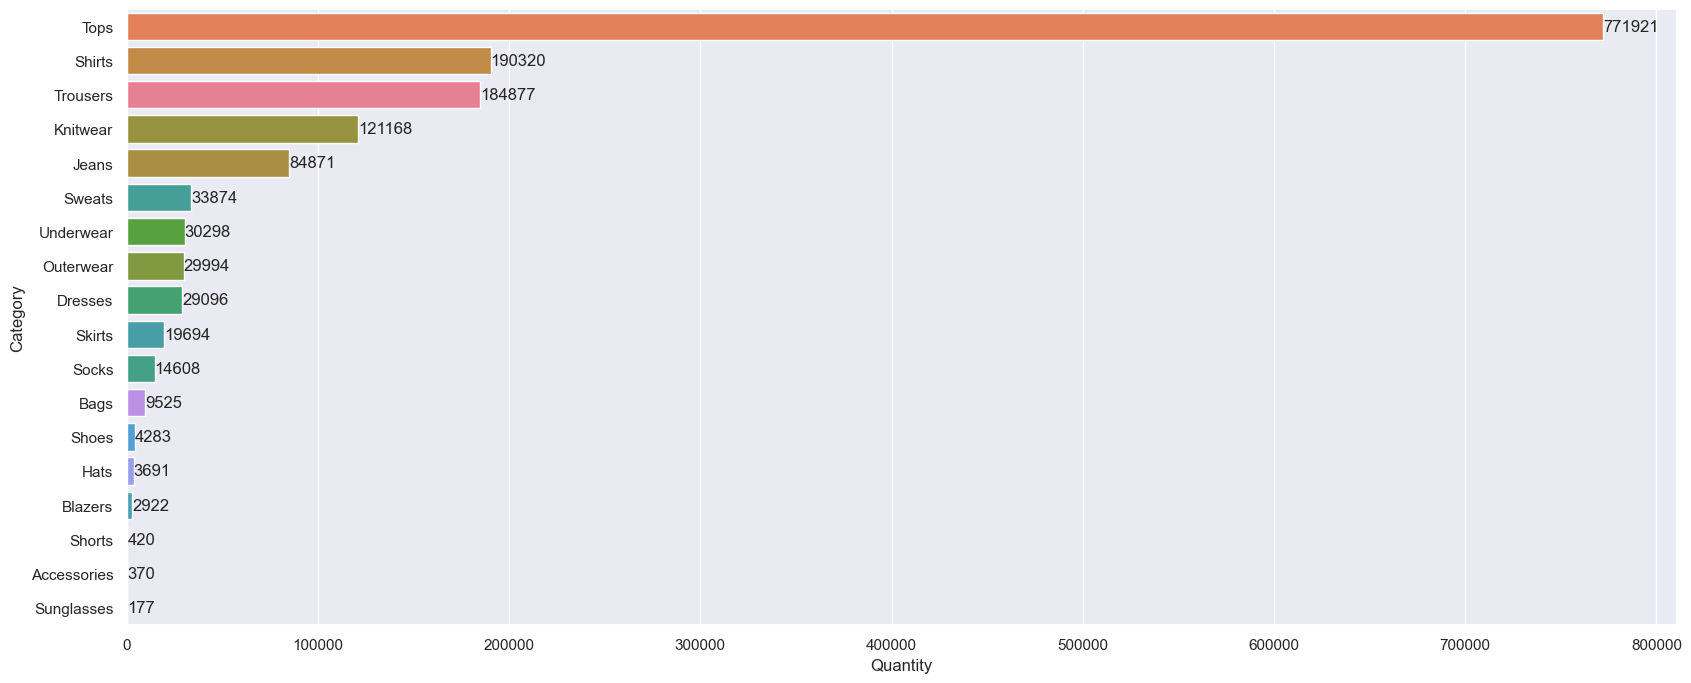

In [266]:
# Bar plot of quantity sold for each categories
temp = df_sales.groupby(["Category"])["Quantity"].sum().sort_values(ascending=False)
ax = sns.barplot(data=df_sales, y="Category", x="Quantity", estimator="sum", hue="Category", errorbar=None, order=temp.index)
for i in ax.containers:
    ax.bar_label(i,)

#### Sales Distribution in Each Category

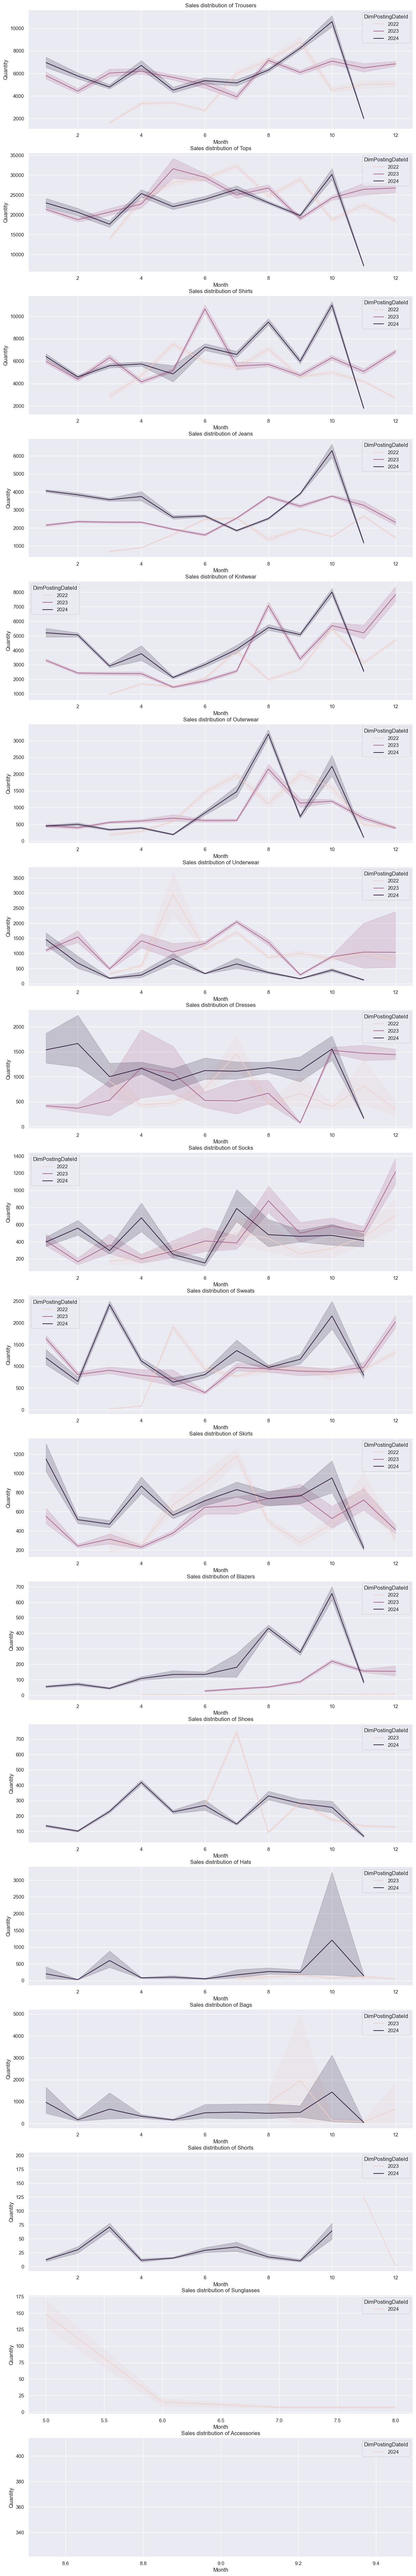

In [267]:
fig, axs = plt.subplots(nrows=df_sales["Category"].nunique(), figsize=(15,100))
j=0
for i in df_sales["Category"].unique():
    temp = df_sales[df_sales["Category"]==i]
    sns.lineplot(data=temp, y="Quantity", x=temp.index.month, estimator="sum", hue=temp.index.year, ax=axs[j]).set(title=f"Sales distribution of {i}", xlabel="Month")
    j+=1

Observations: <br>
1. test

# III. Clustering

## 1. Feature selection

In [268]:
df_sales.head()

,DimGenderId,DimItemId,ItemNo2,StyleID,Style,Color,Size,Gender,Category,SUB Category,SUB Category2,Quality,Origin Country,WHSSalesPriceDKK,RRSalesPriceDKK,OrderHeaderNumber,OrderLineNumber,Quantity,Amount,Discount,Cost
DimPostingDateId,,,,,,,,,,,,,,,,,,,,,
2022-03-12,2,347900,F15404308_CLR000021,F15404308,Hoys pants 6528,Black,XL,WOMENSWEAR,Trousers,Trousers,Default,Woven,China,315.0,800.0,103099,20001,1.0,294.63,17.71,152.91
2022-03-12,2,347900,F15404308_CLR000021,F15404308,Hoys pants 6528,Black,XL,WOMENSWEAR,Trousers,Trousers,Default,Woven,China,315.0,800.0,103106,20002,2.0,589.26,35.34,305.80
2022-03-12,1,778,M00012003_CLR000508,M00012003,Kronos o-n ss 273,White mel,S,MENSWEAR,Tops,Crew neck,Short sleeve,Jersey,Turkey,90.0,250.0,103035,20002,1.0,78.12,0.00,42.41
2022-03-12,2,348547,F19123672_CLR000021,F19123672,Majan ss shirt 9942,Black,L,WOMENSWEAR,Shirts,Shirts,Short sleeve,Woven,China,195.0,500.0,IN0001122,60002,2.0,379.45,0.00,147.84
2022-03-12,2,348547,F19123672_CLR000021,F19123672,Majan ss shirt 9942,Black,L,WOMENSWEAR,Shirts,Shirts,Short sleeve,Woven,China,195.0,500.0,103113,40003,2.0,379.45,0.00,162.08


In [273]:
product_info = df_sales[['ItemNo2','Color','Gender','Category','SUB Category', 'SUB Category2', 'Quality', 'Origin Country']].drop_duplicates()

# Total transactions
total_transactions = df_sales.groupby('ItemNo2')['OrderHeaderNumber'].nunique().reset_index()
total_transactions.rename(columns={'OrderHeaderNumber': 'Total_Transactions'}, inplace=True)

# Calculate the total number of products purchased
total_products = df_sales.groupby('ItemNo2')['Quantity'].sum().reset_index()
total_products.rename(columns={'Quantity': 'Total_Quantity'}, inplace=True)

In [274]:
product_data = product_info

# Merge the new features into the product_data dataframe
product_data = pd.merge(product_data, total_transactions, on='ItemNo2')
product_data = pd.merge(product_data, total_products, on='ItemNo2')

In [282]:
product_data

,ItemNo2,Color,Gender,Category,SUB Category,SUB Category2,Quality,Origin Country,Total_Transactions,Total_Quantity
0,F15404308_CLR000021,Black,WOMENSWEAR,Trousers,Trousers,Default,Woven,China,3728,12154.0
1,M00012003_CLR000508,White mel,MENSWEAR,Tops,Crew neck,Short sleeve,Jersey,Turkey,2266,5749.0
2,F19123672_CLR000021,Black,WOMENSWEAR,Shirts,Shirts,Short sleeve,Woven,China,3576,13351.0
3,F19123672_CLR000289,Clear Cream,WOMENSWEAR,Shirts,Shirts,Short sleeve,Woven,China,4111,17757.0
4,M00012307_CLR000650,Blue Iris Mel,MENSWEAR,Tops,V-neck,Short sleeve,Jersey,Turkey,238,1240.0
...,...,...,...,...,...,...,...,...,...,...
695,M24400088_190414TCX,FOREST NIGHT,MENSWEAR,Shirts,Shirts,Default,Woven,China,5,47.0
696,F24200090_CLR000021,Black,WOMENSWEAR,Skirts,Maxi,Default,Woven,China,27,33.0
697,M24300006_CLR000589,Black Blizzard,MENSWEAR,Jeans,Jeans,Default,Denim,Turkey,7,35.0
698,F24400186_CLR000021,Black,WOMENSWEAR,Knitwear,Cardigan,Long sleeve,Knit,China,11,64.0


In [291]:
# Calculate the total spend for each product
total_spend = df_sales.groupby('ItemNo2')['Amount'].sum().reset_index()
total_spend.rename(columns={'Amount': 'Total_Spend'}, inplace=True)

total_discount = df_sales.groupby('ItemNo2')['Discount'].sum().reset_index()
total_discount.rename(columns={'Discount': 'Total_Discount'}, inplace=True)

# Merge the new features into the product_data dataframe
product_data = pd.merge(product_data, total_spend, on='ItemNo2')
product_data = pd.merge(product_data, total_discount, on='ItemNo2')


In [ ]:
# Average price for each product
product_data["Average_Price"] = product_data["Total_Spend"] / product_data["Total_Quantity"]

In [298]:
# Average discount in percentage of price
product_data["Average_Discount"] = (product_data["Total_Discount"] * 100) / (product_data["Total_Quantity"] * product_data["Average_Price"])

In [325]:
product_data

,ItemNo2,Color,Gender,Category,SUB Category,SUB Category2,Quality,Origin Country,Total_Transactions,Total_Quantity,Total_Spend,Total_Discount,Average_Price,Average_Discount
0,F15404308_CLR000021,Black,WOMENSWEAR,Trousers,Trousers,Default,Woven,China,3728,12154.0,4172555.42,223091.20,343.307176,5.346632
1,M00012003_CLR000508,White mel,MENSWEAR,Tops,Crew neck,Short sleeve,Jersey,Turkey,2266,5749.0,593063.02,47030.50,103.159336,7.930102
2,F19123672_CLR000021,Black,WOMENSWEAR,Shirts,Shirts,Short sleeve,Woven,China,3576,13351.0,2883884.07,122466.83,216.005098,4.246593
3,F19123672_CLR000289,Clear Cream,WOMENSWEAR,Shirts,Shirts,Short sleeve,Woven,China,4111,17757.0,3805570.82,153340.97,214.313838,4.029382
4,M00012307_CLR000650,Blue Iris Mel,MENSWEAR,Tops,V-neck,Short sleeve,Jersey,Turkey,238,1240.0,137106.65,40844.10,110.569879,29.790021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,M24400088_190414TCX,FOREST NIGHT,MENSWEAR,Shirts,Shirts,Default,Woven,China,5,47.0,15329.34,456.53,326.156170,2.978145
696,F24200090_CLR000021,Black,WOMENSWEAR,Skirts,Maxi,Default,Woven,China,27,33.0,13455.40,959.23,407.739394,7.128959
697,M24300006_CLR000589,Black Blizzard,MENSWEAR,Jeans,Jeans,Default,Denim,Turkey,7,35.0,18469.25,464.57,527.692857,2.515370
698,F24400186_CLR000021,Black,WOMENSWEAR,Knitwear,Cardigan,Long sleeve,Knit,China,11,64.0,46475.04,1171.28,726.172500,2.520235


In [336]:
df_wsales = df_sales.groupby([df_sales.index.strftime("%Y-%W"), 'ItemNo2'])[["Quantity", "Amount"]].apply(sum)

C:\Users\MaximeRoux\AppData\Local\Temp\ipykernel_22412\3144899704.py:1: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  df_wsales = df_sales.groupby([df_sales.index.strftime("%Y-%W"), 'ItemNo2'])[["Quantity", "Amount"]].apply(sum)
c:\Users\MaximeRoux\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
